In [48]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [49]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [50]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [51]:
import twosphere_temperature as tst
import pti_model as pti

In [216]:
a1 = 10
a2 = 15
eps_back = 1.473**2

# del_d = 4*a1

d = 3*a1
d_col_cm = np.array([[d, 0, 0]])*1e-7

# hw = 2.2
sensorsize_nm = 1000

plot_hws = np.linspace(2.2, 2.7, 300)


# eps1 = -2.5676 + 1j*3.6391
n0 = eps_back
eps0 = n0**2

## pump power 600 micro watts = 600*1e-6 * 1e7 erg/s
# Eplane = (1.4444)**0.5 * 10**18 * 10**(-1)
Eplane = ((8*np.pi/c)*600*1e-6*1e7)**0.5

In [217]:
## Assign materialk porperties
au_eps_inf=9.82335326  # eps_inf
au_w_p=9.06705560/hbar  # w_p
au_gamma=0.0334860149/hbar  # gamma

In [218]:
def alpha_1_of_hw(hw):
    return cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
#         eps_inf=14.2, 
#         w_p=10.0/hbar, 
#         gamma=0.20/hbar,
#         eps_b=1.33**2., 
        a=a1*1e-7, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )

def alpha_2_of_hw(hw):
    return cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
        a=a2*1e-7, 
        )

In [219]:
plot_hws = np.linspace(2.25, 2.5, 300)

sphere_1_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_1_of_hw(plot_hws)[:, 0, 0])**2.
    )
sphere_2_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_2_of_hw(plot_hws)[:, 0, 0])**2.
    )

# plt.plot(plot_hws, sphere_1_scattering)
# plt.plot(plot_hws, sphere_2_scattering)
# plt.title("Heterodimer Scattering")
# plt.xlabel('Photon Energy [eV]')
# plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')


In [220]:
def coupled_dips_of_w(w):
    return  cp.coupled_dip_mags_both_driven(
        mol_angle=0,
        plas_angle=0,
        d_col = d_col_cm,
        E_d_angle=None,
        drive_hbar_w=w*hbar,
        alpha0_diag=alpha_1_of_hw(w*hbar),
        alpha1_diag=alpha_2_of_hw(w*hbar),
        n_b=eps_back**0.5,
        drive_amp=Eplane,)

coupled_scattering = cp.sigma_scat_coupled(
    dipoles_moments_per_omega=coupled_dips_of_w,
    d_col=d_col_cm,
    drive_hbar_w=plot_hws,
    n_b=eps_back**0.5,
    E_0=Eplane,)


In [221]:
# plt.plot(plot_hws, coupled_scattering[0], label='Coupled')
# # plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# # plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

# plt.plot(plot_hws, sphere_1_scattering, ls='--', label='isolated sphere 1')
# plt.plot(plot_hws, sphere_2_scattering, ls='--', label='isolated sphere 2')
# plt.legend(fontsize=6)
# plt.title("Heterodimer Scattering")
# plt.xlabel('Photon Energy [eV]')
# plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

In [222]:

coupled_absorption = cp.sigma_abs_coupled(
    mol_angle=0,
    plas_angle=0,
    d_col = d_col_cm,
    E_d_angle=None,
    drive_hbar_w=plot_hws,
    alpha0_diag=alpha_1_of_hw(plot_hws),
    alpha1_diag=alpha_2_of_hw(plot_hws),
    n_b=eps_back**0.5,
    drive_amp=Eplane,)

sphere_1_absorption = cp.single_dip_absorption(
    mol_angle=0,
    E_d_angle=0,
    alpha_0_p0=alpha_1_of_hw(plot_hws),
    drive_hbar_w=plot_hws,
    drive_amp=Eplane,
    n_b=eps_back**0.5,)

sphere_2_absorption = cp.single_dip_absorption(
    mol_angle=0,
    E_d_angle=0,
    alpha_0_p0=alpha_2_of_hw(plot_hws),
    drive_hbar_w=plot_hws,
    drive_amp=Eplane,
    n_b=eps_back**0.5,)

In [223]:
# plt.plot(plot_hws, coupled_absorption[0], label='Coupled')
# # plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# # plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

# # plt.plot(plot_hws, sphere_1_absorption, ls='--', label='isolated sphere 1')
# # plt.plot(plot_hws, sphere_2_absorption, ls='--', label='isolated sphere 2')


# plt.legend(fontsize=6)
# plt.title("Heterodimer Absorption")
# plt.xlabel('Photon Energy [eV]')
# plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

Plot dipole components of power absorbed

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

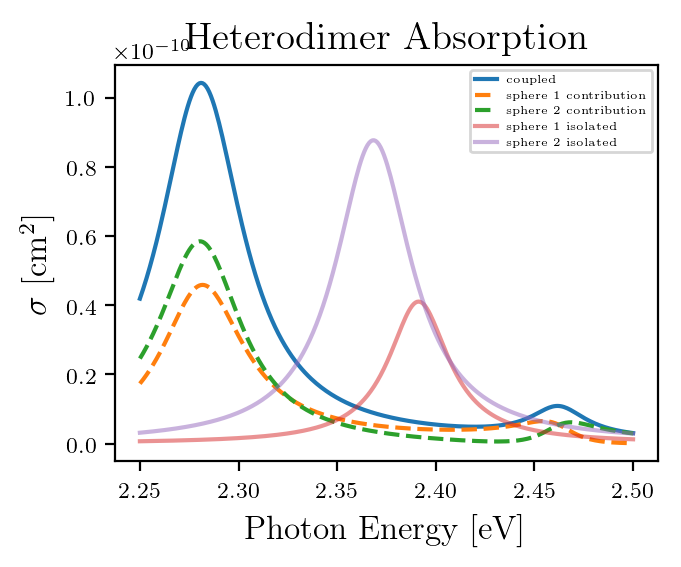

In [224]:
# plt.plot(plot_hws, coupled_absorption[0], label='Coupled')
plt.plot(
    plot_hws, 
    coupled_absorption[1][0]-coupled_absorption[1][1]+coupled_absorption[1][2]-coupled_absorption[1][3], 
#     ls='--',
    label='coupled')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

plt.plot(
    plot_hws, 
    coupled_absorption[1][0]-coupled_absorption[1][1], 
    ls='--', 
    label='sphere 1 contribution')
plt.plot(
    plot_hws, 
    coupled_absorption[1][2]-coupled_absorption[1][3], 
    ls='--', 
    label='sphere 2 contribution')


plt.plot(plot_hws, sphere_1_absorption, alpha=.5, label='sphere 1 isolated')
plt.plot(plot_hws, sphere_2_absorption, alpha=.5, label='sphere 2 isolated')

plt.legend(fontsize=4)
plt.title("Heterodimer Absorption")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

which supports what I would have expected, that the larger sphere is dominating absorption at the low energy mode

Find peak energies

In [225]:
bond_enei = plot_hws[np.argmax(coupled_scattering[0])]
anti_enei = plot_hws[round(len(plot_hws)/2)+
    np.argmax(coupled_scattering[0][round(len(plot_hws)/2):])]

In [226]:
bond_enei

2.279264214046823

In [227]:
# anti_enei=2.4
anti_enei

2.4648829431438126

# CAlculate coupled abs for pump excitation

In [228]:
eps_at_bond = cp.drude_model(
    w=bond_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)
eps_at_anti = cp.drude_model(
    w=anti_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)

In [229]:
# obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7


## Back to calcs

In [230]:
bond_alpha_1 = alpha_1_of_hw(bond_enei)
bond_alpha_2 = alpha_2_of_hw(bond_enei)

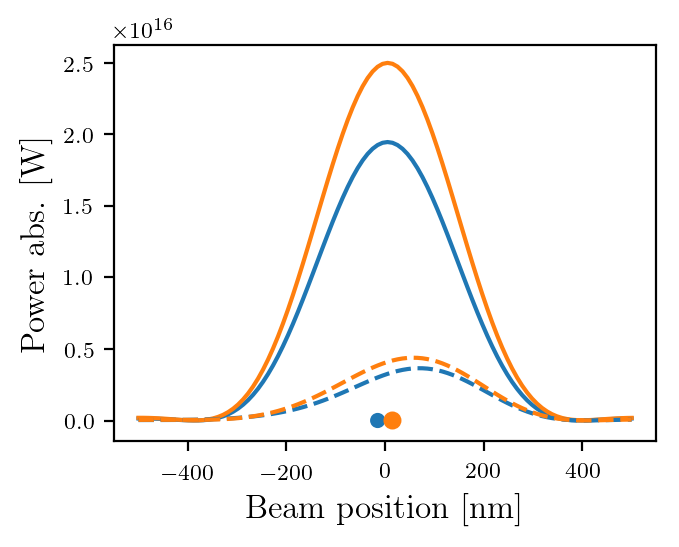

In [231]:
obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

bond_p1_pumped, bond_p2_pumped = cp.coupled_dip_mags_focused_beam(
    mol_angle=0,
    plas_angle=0,
    d_col = -d_col_cm,
    p0_position=-d_col_cm/2,
    beam_x_positions=obs_points,
    E_d_angle=0,
    drive_hbar_w=bond_enei,
    alpha0_diag=alpha_1_of_hw(bond_enei),
    alpha1_diag=alpha_2_of_hw(bond_enei),
    n_b=eps_back**0.5,
    drive_amp=Eplane,
    return_polarizabilities=False,
    )

bond_p1_pumped_pow = cp.power_absorped(
    bond_p1_pumped, 
    alpha_1_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)

bond_p2_pumped_pow = cp.power_absorped(
    bond_p2_pumped, 
    alpha_2_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)

## Antibonding mode
# obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

anti_p1_pumped, anti_p2_pumped = cp.coupled_dip_mags_focused_beam(
    mol_angle=0,
    plas_angle=0,
    d_col=-d_col_cm,
    p0_position=-d_col_cm/2,
    beam_x_positions=obs_points,
    E_d_angle=0,
    drive_hbar_w=anti_enei,
    alpha0_diag=alpha_1_of_hw(anti_enei),
    alpha1_diag=alpha_2_of_hw(anti_enei),
    n_b=eps_back**0.5,
    drive_amp=Eplane,
    return_polarizabilities=False,
    )

anti_p1_pumped_pow = cp.power_absorped(
    anti_p1_pumped, 
    alpha_1_of_hw(anti_enei),
    anti_enei,
    n_b=eps_back**0.5)

anti_p2_pumped_pow = cp.power_absorped(
    anti_p2_pumped, 
    alpha_2_of_hw(anti_enei),
    anti_enei,
    n_b=eps_back**0.5)

## Make plots

plt.plot(obs_points*1e7, bond_p1_pumped_pow*1e-7, label='bonding')
plt.plot(obs_points*1e7, bond_p2_pumped_pow*1e-7, label='bonding')

plt.plot(obs_points*1e7, anti_p1_pumped_pow*1e-7, ls='--', label='antibonding', c='C0')
plt.plot(obs_points*1e7, anti_p2_pumped_pow*1e-7, ls='--', label='antibonding', c='C1')

plt.xlabel('Beam position [nm]')
plt.ylabel('Power abs. [W]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
# plt.title('Bonding mode', fontsize=10)

## Calculate temperatures
but first we need flux from power absorbed

In [232]:
sph_1_area = 4*np.pi*(a1*1e-9)**2.
sph_2_area = 4*np.pi*(a2*1e-9)**2.

bond_flux_1 = bond_p1_pumped_pow / sph_1_area
bond_flux_2 = bond_p2_pumped_pow / sph_2_area

anti_flux_1 = anti_p1_pumped_pow / sph_1_area
anti_flux_2 = anti_p2_pumped_pow / sph_2_area

Text(0.5, 0, 'Beam position [nm]')

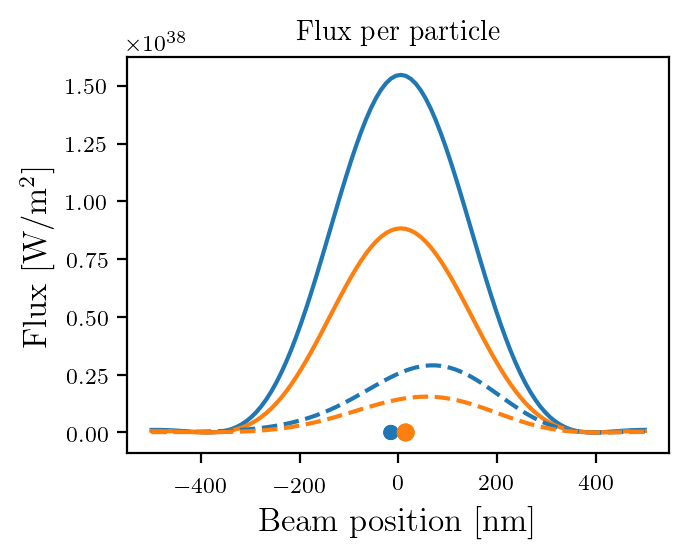

In [233]:
plt.plot(obs_points*1e7, bond_flux_1, label='bonding')
plt.plot(obs_points*1e7, bond_flux_2, label='bonding')
plt.ylabel(r'Flux [W/$\mathrm{m}^2$]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.title('Bonding mode', fontsize=10)
plt.xlabel('Beam position [nm]')

plt.plot(obs_points*1e7, anti_flux_1, ls='--', label='antibonding', c='C0')
plt.plot(obs_points*1e7, anti_flux_2, ls='--', label='antibonding', c='C1')
plt.ylabel(r'Flux [W/$\mathrm{m}^2$]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.title('Flux per particle', fontsize=10)
plt.xlabel('Beam position [nm]')

In [234]:
epsilon = 2*a1/d
l2_on_l1 = a2/a1

In [235]:
epsilon

0.6666666666666666

Text(0, 0.5, '$\\propto (T- T_r)$')

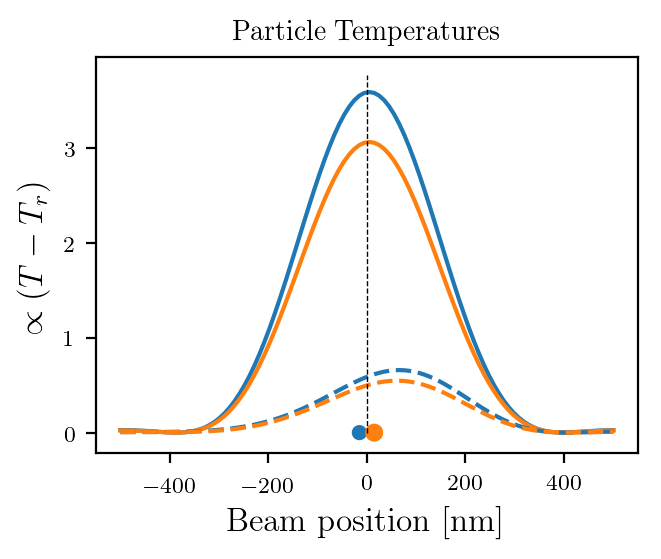

In [236]:
 ## Try this again 
bond_flux_ratios = bond_flux_2 / bond_flux_1

bond_temps = np.zeros_like(bond_flux_ratios)
bond_temps = bond_temps[None, :]*np.ones((2,1))

for i, q_ratio in enumerate(bond_flux_ratios):
    bond_temps[0, i] = tst.hetero_sph_unitless_temp(
        which_sphere=1,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    bond_temps[1, i] = tst.hetero_sph_unitless_temp(
        which_sphere=2,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    

## Antibonding Mode calculation

anti_temps = np.zeros_like(bond_flux_ratios)
anti_temps = anti_temps[None, :]*np.ones((2,1))

for i, q_ratio in enumerate(anti_flux_2/anti_flux_1):
    anti_temps[0, i] = tst.hetero_sph_unitless_temp(
        which_sphere=1,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    anti_temps[1, i] = tst.hetero_sph_unitless_temp(
        which_sphere=2,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)


## Convert Temperature to Kelvin
def bond_temp_to_kelvin(theta):
    return theta*(bond_flux_1*a1*1e-9/kappa_glycerol)*5e-31
def anti_temp_to_kelvin(theta):
    return theta*(anti_flux_1*a1*1e-9/kappa_glycerol)*5e-31

## Make Plots
plt.plot(
    obs_points*1e7, 
    bond_temp_to_kelvin(bond_temps[0, :]), 
    label='bonding')
plt.plot(
    obs_points*1e7, 
    bond_temp_to_kelvin(bond_temps[1, :]), 
    label='bonding')

plt.plot(
    obs_points*1e7, 
    anti_temp_to_kelvin(anti_temps[0, :]), 
    ls='--', label='antibonding', c='C0')
plt.plot(
    obs_points*1e7, 
    anti_temp_to_kelvin(anti_temps[1, :]), 
    ls='--', label='antibonding', c='C1')

plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')
plt.title('Particle Temperatures', fontsize=10)
plt.xlabel('Beam position [nm]')
plt.ylabel(r'$\propto (T- T_r)$')

# Build PTImages

In [238]:
probe_enei = 2.5

bond_heated_particles = pti.temperature_dependent_particle(
    probe_enei, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma)

bond_conf_image = bond_heated_particles.conf_PTI(
    obs_points*1e7, 
    probe_enei, 
    T1=bond_temp_to_kelvin(bond_temps[0, :]), 
    b1=a1+5, 
    T2=bond_temp_to_kelvin(bond_temps[1, :]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)


### Calculate widefield image 
bond_p1_wf_pumped, bond_p2_wf_pumped = cp.coupled_dip_mags_both_driven(
    mol_angle=0,
    plas_angle=0,
    d_col=-d_col_cm,
    E_d_angle=0,
    drive_hbar_w=bond_enei,
    alpha0_diag=alpha_1_of_hw(bond_enei),
    alpha1_diag=alpha_2_of_hw(bond_enei),
    n_b=eps_back**0.5,
    drive_amp=Eplane,
    return_polarizabilities=False,
    )

bond_p1_wf_pumped_pow = cp.power_absorped(
    bond_p1_wf_pumped, 
    alpha_1_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)

bond_p2_wf_pumped_pow = cp.power_absorped(
    bond_p2_wf_pumped, 
    alpha_2_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)


bond_flux_wf_1 = bond_p1_wf_pumped_pow / sph_1_area
bond_flux_wf_2 = bond_p2_wf_pumped_pow / sph_2_area
q_ratio = (bond_flux_wf_2/bond_flux_wf_1)[0]
## Calculate sphere temperatures
bond_temps_wf = [0, 0]

bond_temps_wf[0] = tst.hetero_sph_unitless_temp(
    which_sphere=1,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)
bond_temps_wf[1] = tst.hetero_sph_unitless_temp(
    which_sphere=2,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)

bond_wifi_image = bond_heated_particles.wfi_pti(
    l=obs_points*1e7, 
    w=probe_enei/hbar, 
    T1=bond_temp_to_kelvin(bond_temps_wf[0]), 
    b1=a1+5, 
    T2=bond_temp_to_kelvin(bond_temps_wf[1]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)


# plt.plot(
#     obs_points*1e7,
#     np.abs(bond_conf_image)/np.abs(bond_conf_image).max(),
#     label='confocal',
#     c='C3')

# plt.plot(
#     obs_points*1e7,
#     np.abs(bond_wifi_image)/np.abs(bond_wifi_image).max(),
#     label='widefield',
#     c='C4')

# plt.scatter(
#     np.asarray([-1, 1])*d/2,
#     [0,0],
#     c=['C0','C1'],
#     s=[a1*2,a2*2])
# plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')

# plt.legend()
# plt.title("Bonding mode PTImages")
# plt.xlabel('[nm]')
# plt.ylabel('PT signal')


In [240]:
probe_enei = 2.5

anti_heated_particles = pti.temperature_dependent_particle(
    probe_enei, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma)

anti_conf_image = anti_heated_particles.conf_PTI(
    obs_points*1e7, 
    probe_enei, 
    T1=anti_temp_to_kelvin(anti_temps[0, :]), 
    b1=a1+5, 
    T2=anti_temp_to_kelvin(anti_temps[1, :]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)


### Calculate widefield image 
anti_p1_wf_pumped, anti_p2_wf_pumped = cp.coupled_dip_mags_both_driven(
    mol_angle=0,
    plas_angle=0,
    d_col=-d_col_cm,
    E_d_angle=0,
    drive_hbar_w=anti_enei,
    alpha0_diag=alpha_1_of_hw(anti_enei),
    alpha1_diag=alpha_2_of_hw(anti_enei),
    n_b=eps_back**0.5,
    drive_amp=Eplane,
    return_polarizabilities=False,
    )

anti_p1_wf_pumped_pow = cp.power_absorped(
    anti_p1_wf_pumped, 
    alpha_1_of_hw(anti_enei),
    anti_enei,
    n_b=eps_back**0.5)

anti_p2_wf_pumped_pow = cp.power_absorped(
    anti_p2_wf_pumped, 
    alpha_2_of_hw(anti_enei),
    anti_enei,
    n_b=eps_back**0.5)


anti_flux_wf_1 = anti_p1_wf_pumped_pow / sph_1_area
anti_flux_wf_2 = anti_p2_wf_pumped_pow / sph_2_area
q_ratio = (anti_flux_wf_2/anti_flux_wf_1)[0]
## Calculate sphere temperatures
anti_temps_wf = [0, 0]

anti_temps_wf[0] = tst.hetero_sph_unitless_temp(
    which_sphere=1,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)
anti_temps_wf[1] = tst.hetero_sph_unitless_temp(
    which_sphere=2,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)

anti_wifi_image = anti_heated_particles.wfi_pti(
    l=obs_points*1e7, 
    w=probe_enei/hbar, 
    T1=anti_temp_to_kelvin(anti_temps_wf[0]), 
    b1=a1+5, 
    T2=anti_temp_to_kelvin(anti_temps_wf[1]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)


# plt.plot(
#     obs_points*1e7,
#     np.abs(anti_conf_image)/np.abs(anti_conf_image).max(),
#     label='confocal',
#     c='C3')

# plt.plot(
#     obs_points*1e7,
#     np.abs(anti_wifi_image)/np.abs(anti_wifi_image).max(),
#     label='widefield',
#     c='C4')

# plt.scatter(
#     np.asarray([-1, 1])*d/2,
#     [0,0],
#     c=['C0','C1'],
#     s=[a1*2,a2*2])
# plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')

# plt.legend()
# plt.title("Antibonding mode PTImages")
# plt.xlabel('[nm]')
# plt.ylabel('PT signal')

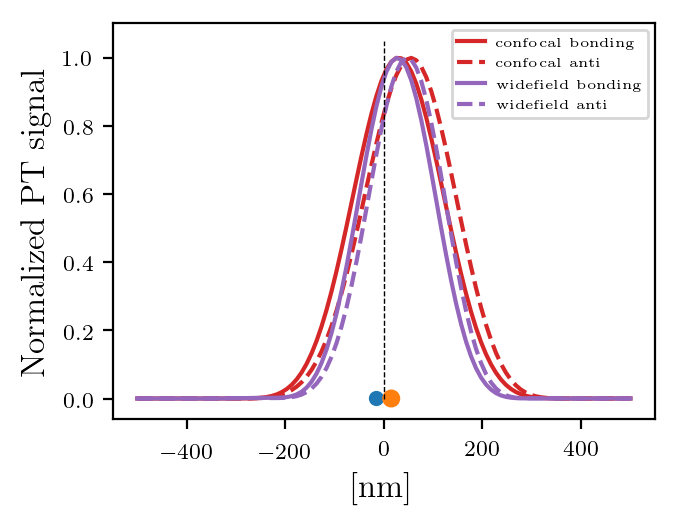

In [241]:
plt.plot(
    obs_points*1e7,
    np.abs(bond_conf_image)/np.abs(bond_conf_image).max(),
    label='confocal bonding',
    c='C3')
plt.plot(
    obs_points*1e7,
    np.abs(anti_conf_image)/np.abs(anti_conf_image).max(),
    label='confocal anti',
    ls = '--',
    c='C3'
    )


plt.plot(
    obs_points*1e7,
    np.abs(bond_wifi_image)/np.abs(bond_wifi_image).max(),
    label='widefield bonding',
    c='C4')


plt.plot(
    obs_points*1e7,
    np.abs(anti_wifi_image)/np.abs(anti_wifi_image).max(),
    label='widefield anti',
    ls = '--',
    c='C4'
    )


plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')
# plt.xlim(-200, 200)
plt.legend(fontsize=5)
plt.xlabel('[nm]')
plt.ylabel('Normalized PT signal')
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])